# 8.1 LSTM으로 텍스트 생성하기

## 8.1.4 글자 수준의 LSTM 텍스트 생성 모델 구현

In [0]:
# 원본 텍스트 파일을 내려받아 파싱하기
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('말뭉치 크기:', len(text))

Using TensorFlow backend.


말뭉치 크기: 600893


In [0]:
# 글자 시퀀스 벡터화하기
maxlen = 60  # 60개 글자로 된 시퀀스를 추출합니다.
step = 3  # 세 글자씩 건너 뛰면서 새로운 시퀀스를 샘플링합니다.

sentences = [] # 추출한 시퀀스를 담을 리스트   

next_chars = []   # 타깃(시퀀스 다음 글자)을 담을 리스트

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('시퀀스 개수:', len(sentences))

chars = sorted(list(set(text)))  # 말뭉치에서 고유한 글자를 담은 리스트
print('고유한 글자:', len(chars))
char_indices = dict((char, chars.index(char)) for char in chars)  # chars 리스트에 있는 글자와 글자의 인덱스를 매핑한 딕셔너리

# 글자를 원-핫 인코딩하여 0과 1의 이진 배열로 바꿉니다.
print('벡터화...')  
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

시퀀스 개수: 200278
고유한 글자: 57
벡터화...


In [0]:
# 다음 글자를 예측하기 위한 단일 LSTM 모델
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [0]:
# 모델 컴파일 설정하기
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
# 모델의 예측이 주어졌을 때 새로운 글자를 샘플링하는 함수
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
# 텍스트 생성 루프
import random
import sys

random.seed(42)
start_index = random.randint(0, len(text) - maxlen - 1)

# 60 에포크 동안 모델을 훈련합니다
for epoch in range(1, 60):
    print('에포크', epoch)
    # 데이터에서 한 번만 반복해서 모델을 학습합니다
    model.fit(x, y, batch_size=128, epochs=1)

    # 무작위로 시드 텍스트를 선택합니다
    seed_text = text[start_index: start_index + maxlen]
    print('--- 시드 텍스트: "' + seed_text + '"')

    # 여러가지 샘플링 온도를 시도합니다
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ 온도:', temperature)
        generated_text = seed_text
        sys.stdout.write(generated_text)

        # 시드 텍스트에서 시작해서 400개의 글자를 생성합니다
        for i in range(400):
            # 지금까지 생성된 글자를 원-핫 인코딩으로 바꿉니다
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            # 다음 글자를 샘플링합니다
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

에포크 1
Epoch 1/1
200278/200278 [==============================] - 332s 2ms/step - loss: 1.9618
--- 시드 텍스트: "the slowly ascending ranks and classes, in which,
through fo"
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the proble of the sense of the desire of the sense the self-conselve of the will which a man of the self-conselves of the self-conselves of the manity of the self-conselved to the sense the more and with the self-conselve of the man which is a man which a man of the self-conselves to the sense of the self-conselves of the consequent of the sense of the consequent of the self-conscient of the sen
------ 온도: 0.5
the slowly ascending ranks and classes, in which,
through for man the probection of the sour of the men tool to the sense the more and main of which he sense the self-conselves with the proble the concention and superience of the degeal to and conclusion and something the in lights of the caud of the coured as the sense the self-and any t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


e but a heart the self-contempthy in a such and most consequence, and but a demands the same the entire and praise of the same the same conscience of prosight in the masters of self convinted the man has bee
------ 온도: 1.0
the slowly ascending ranks and classes, in which,
through form and worldiness: "every beliefting stee untoldiere, should mild of jeapow affher called, in it has a the wishor of a cognizing example
of dis" and that the buting the goes ideas of its, to attains established by a crejuries to the self-danger and that is a igkes, understand
new how there are woman hitherto growing condition inmpisting and very german estimation of world astronation is refeet eme
------ 온도: 1.2
the slowly ascending ranks and classes, in which,
through force of theo
was, as asside procefs who are
could be kinlate, will
sgearification towards and tegaties,
wonalini chycas, very moral for
othirsi our sentiment
of eyest
rywdomness, he coves to all the restading old
immediate about the best-re. 

# 8.2 딥드림

## 8.2.1 케라스 딥드림 구현

In [0]:
# 사전 훈련된 입셉션 V3 모델 로드하기
from keras.applications import inception_v3
from keras import backend as K

# 모델을 훈련하지 않습니다. 이 명령은 모든 훈련 연산을 비활성화합니다
K.set_learning_phase(0)

# 합성곱 기반층만 사용한 인셉션 V3 네트워크를 만듭니다. 사전 훈련된 ImageNet 가중치와 함께 모델을 로드합니다
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

In [0]:
# 딥드림 설정하기

# 층 이름과 계수를 매핑한 딕셔너리.
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정합니다.
# 층 이름은 내장된 인셉션 V3 애플리케이션에 하드코딩되어 있는 것입니다.
# model.summary()를 사용하면 모든 층 이름을 확인할 수 있습니다
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [0]:
# 최대화할 손실 정의하기

# 층 이름과 층 객체를 매핑한 딕셔너리를 만듭니다.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가할 것입니다
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    # 층의 출력을 얻습니다
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 층 특성의 L2 노름의 제곱을 손실에 추가합니다. 이미지 테두리는 제외하고 손실에 추가합니다.
    loss =+ coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [0]:
# 경사 상승법 과정

# 이 텐서는 생성된 딥드림 이미지를 저장합니다
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트를 계산합니다
grads = K.gradients(loss, dream)[0]

# 그래디언트를 정규화합니다(이 기교가 중요합니다)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 Function 객체를 만듭니다
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [0]:
# 유틸리티 함수
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# 연속적인 스케일에 걸쳐 경사 상승법 실행하기
import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어집니다
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지합니다
max_loss = 10.

# 사용할 이미지 경로를 씁니다
base_image_path = '/content/datasets/original_photo_deep_dream.jpg'

# 기본 이미지를 넘파이 배열로 로드합니다
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비합니다
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='/content/datasets/final_dream.png')


처리할 이미지 크기 (178, 178)
... 0 번째 손실 : 0.08422812
... 1 번째 손실 : 0.13463995
... 2 번째 손실 : 0.18777871
... 3 번째 손실 : 0.24311297
... 4 번째 손실 : 0.29969138
... 5 번째 손실 : 0.35345596
... 6 번째 손실 : 0.43850398
... 7 번째 손실 : 0.5270229
... 8 번째 손실 : 0.6048345
... 9 번째 손실 : 0.6954611
... 10 번째 손실 : 0.7919404
... 11 번째 손실 : 0.9493565
... 12 번째 손실 : 1.1211686
... 13 번째 손실 : 1.2477558
... 14 번째 손실 : 1.411928
... 15 번째 손실 : 1.594163
... 16 번째 손실 : 1.7550504
... 17 번째 손실 : 1.9159964
... 18 번째 손실 : 2.092357
... 19 번째 손실 : 2.274946
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 0.20317526
... 1 번째 손실 : 0.38647488
... 2 번째 손실 : 0.58253473
... 3 번째 손실 : 0.79338443
... 4 번째 손실 : 0.9362453
... 5 번째 손실 : 0.98986566
... 6 번째 손실 : 1.3238472
... 7 번째 손실 : 1.4715093
... 8 번째 손실 : 1.7229948
... 9 번째 손실 : 1.8730423
... 10 번째 손실 : 2.0342236
... 11 번째 손실 : 2.2268329
... 12 번째 손실 : 2.3546317
... 13 번째 손실 : 2.5475173
... 14 번째 손실 : 2.8930275
... 15 번째 손실 : 2.9877641
... 16 번째 손실 : 3.2538788
... 17 번째 손실 : 3.3365197
... 18 번째 손실 : 3.6

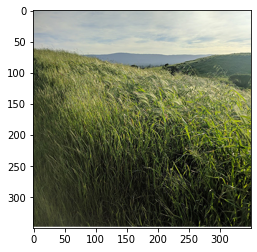

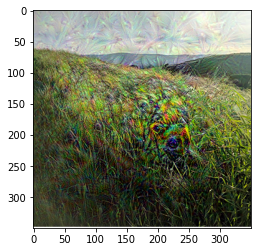

In [0]:
from matplotlib import pyplot as plt

plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

# 8.3 뉴럴 스타일 트랜스퍼

## 8.3.3 케라스에서 뉴럴 스타일 트랜스퍼 구현하기

In [0]:
# 변수 초깃값 정의하기
from keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = '/content/datasets/portrait.jpg'
# 스타일 이미지 경로
style_reference_image_path = '/content/datasets/popova.jpg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [0]:
# 유틸리티 함수
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# 사전 훈련된 VGG19 네트워크를 로딩하고 3개 이미지에 적용하기
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')

모델 로드 완료.


In [0]:
# 콘텐츠 손실
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
# 스타일 손실
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# 총 변위 손실
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# 최소화할 최종 손실 정의하기
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss =+ content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss =+ (style_weight / len(style_layers)) * sl
loss =+ total_variation_weight * total_variation_loss(combination_image)

In [0]:
# 경사 하강법 단계 설정하기
# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [0]:
# 스타일 트랜스퍼 반복 루프
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 1232.3397
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 3s
반복 횟수: 1
현재 손실 값: 384.84488
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 3s
반복 횟수: 2
현재 손실 값: 190.9184
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 3s
반복 횟수: 3
현재 손실 값: 111.69637
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 3s
반복 횟수: 4
현재 손실 값: 77.616776
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 3s
반복 횟수: 5
현재 손실 값: 55.973557
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 3s
반복 횟수: 6
현재 손실 값: 43.95815
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 3s
반복 횟수: 7
현재 손실 값: 36.000572
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 3s
반복 횟수: 8
현재 손실 값: 30.388662
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 3s
반복 횟수: 9
현재 손실 값: 25.902613
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 3s
반복 횟수: 10
현재 손실 값: 22.74113
저장 이미지:  style_transfer_result_at_iteration_

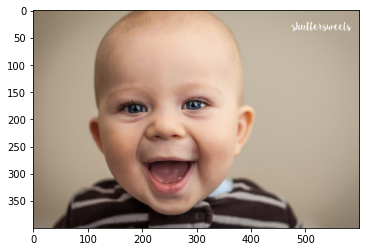

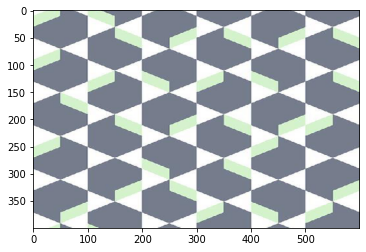

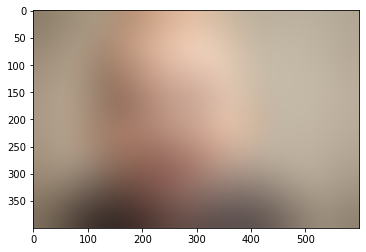

In [0]:
from matplotlib import pyplot as plt

# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()